## PyTorch Convolutional Neural Networks (CNN)

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import transforms, datasets
import torch.nn.functional as F
torch.manual_seed(42)

from PIL import Image
from IPython.display import display
from dataclasses import dataclass
import matplotlib.pyplot as plt
import random
import numpy as np
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Defining Hyperparameters

In [27]:
@dataclass
class Config:
    BATCH_SIZE = 64
    EPOCHS = 200
    PATIENCE = 5

## Defining a Dataset Class

In [28]:
# Define overall dataset class
class RPSDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.dataset = datasets.ImageFolder(self.data_dir, transform=self.transform)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        return self.dataset[index]

### Defining Transforms

In [29]:
# Define the transforms to use
data_transforms = transforms.Compose([
    transforms.Resize((90, 90)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [30]:
# Instantiate a Dataset
dataset = RPSDataset('data/cnn/image_data/', transform=data_transforms)

### Exploring the Dataset

In [31]:
# Exploring the Dataset
print(dataset[0])

# Returns:
# (tensor([[[-0.9529, -0.9529, -0.9529,  ..., -0.9529, -0.9529, -0.9529],
#           [-0.9529, -0.9529, -0.9529,  ..., -0.9529, -0.9529, -0.9529],
#           [-0.9529, -0.9529, -0.9529,  ..., -0.9529, -0.9529, -0.9529],
#           ...,
#           [-0.9529, -0.9529, -0.9529,  ..., -0.9529, -0.9529, -0.9529],
#           [-0.9529, -0.9529, -0.9529,  ..., -0.9529, -0.9529, -0.9529],
#           [-0.9529, -0.9529, -0.9529,  ..., -0.9529, -0.9529, -0.9529]]]),
#  0)

(tensor([[[-0.9294, -0.9294, -0.9294,  ..., -0.9294, -0.9294, -0.9294],
         [-0.9294, -0.9294, -0.9294,  ..., -0.9294, -0.9294, -0.9294],
         [-0.9294, -0.9294, -0.9294,  ..., -0.9294, -0.9294, -0.9294],
         ...,
         [-0.9294, -0.9294, -0.9294,  ..., -0.9294, -0.9294, -0.9294],
         [-0.9294, -0.9294, -0.9294,  ..., -0.9294, -0.9294, -0.9294],
         [-0.9294, -0.9294, -0.9294,  ..., -0.9294, -0.9294, -0.9294]],

        [[-0.9294, -0.9294, -0.9294,  ..., -0.9294, -0.9294, -0.9294],
         [-0.9294, -0.9294, -0.9294,  ..., -0.9294, -0.9294, -0.9294],
         [-0.9294, -0.9294, -0.9294,  ..., -0.9294, -0.9294, -0.9294],
         ...,
         [-0.9294, -0.9294, -0.9294,  ..., -0.9294, -0.9294, -0.9294],
         [-0.9294, -0.9294, -0.9294,  ..., -0.9294, -0.9294, -0.9294],
         [-0.9294, -0.9294, -0.9294,  ..., -0.9294, -0.9294, -0.9294]],

        [[-0.9294, -0.9294, -0.9294,  ..., -0.9294, -0.9294, -0.9294],
         [-0.9294, -0.9294, -0.9294,  ..., -

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


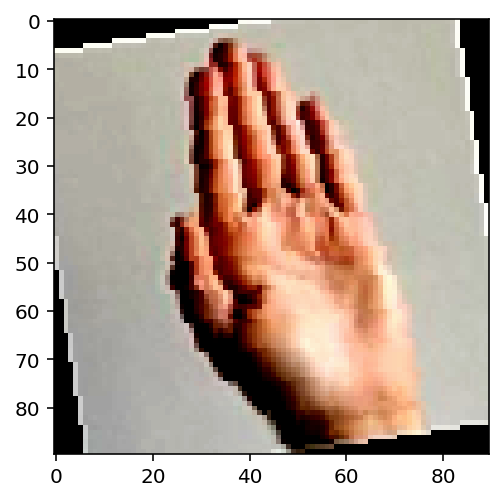

In [32]:
plt.imshow(dataset[0][0].numpy().transpose(1, 2, 0))

In [33]:
# Get variables for Classes and Indices
classes_to_idx = dataset.dataset.class_to_idx
idx_to_classes = {v: k for k, v in classes_to_idx.items()}

### Splitting the Dataset

In [34]:
# Split into Train/Test Datasets
train_data, test_data = random_split(dataset, lengths=[0.8, 0.2])

### Exploring the Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


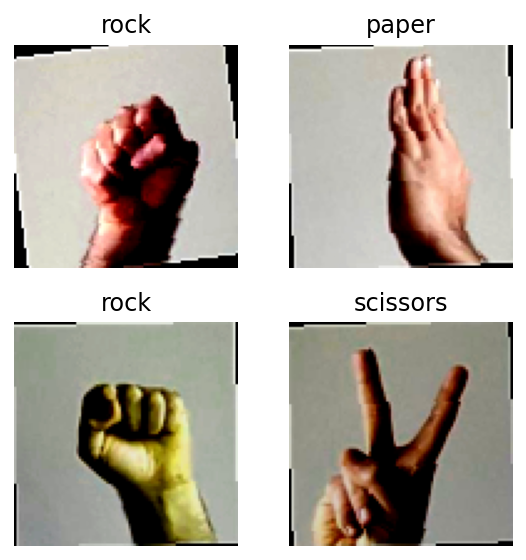

In [35]:
# Generate a list of four random indices
indices = random.sample(range(len(dataset)), 4)

# Plot four random images from the dataset
fig, axes = plt.subplots(2, 2, figsize=(4, 4))
for i, ax in zip(indices, axes.flat):
    # Get an image and its corresponding class from the dataset
    image, target = dataset[i]
    
    # Plot the image
    ax.imshow(image.permute(1,2,0))
    ax.axis('off')
    
    # Set the class name as the title
    class_name = dataset.dataset.classes[target]
    ax.set_title(class_name)

plt.tight_layout()
plt.show();

## Creating DataLoaders

In [36]:
train_loader = DataLoader(train_data, batch_size=Config.BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=Config.BATCH_SIZE, shuffle=True)

In [37]:
# Exploring a DataLoader Batch
iterator = iter(train_loader)
imgs, labels = next(iterator)

print(f'Number of images: {len(imgs)}')
print(f'Number of labels: {len(labels)}')
print(f'Shape of images batch: {np.array(imgs).shape}')

Number of images: 64
Number of labels: 64
Shape of images batch: (64, 3, 90, 90)


In [38]:
class RPSClassifier(nn.Module):
    def __init__(self):
        super(RPSClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 20 * 20, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 20 * 20)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [39]:
conv1 = nn.Conv2d(3,6,3)
pool = nn.MaxPool2d(2,2)
conv2 = nn.Conv2d(6,16,5)
img_conv1 = conv1(dataset[0][0])
img_pool1 = pool(img_conv1)
img_conv2 = conv2(img_pool1)
img_pool2 = pool(img_conv2)

print(f'{img_conv1.shape=}')
print(f'{img_pool1.shape=}')
print(f'{img_conv2.shape=}')
print(f'{img_pool2.shape=}')

img_conv1.shape=torch.Size([6, 88, 88])
img_pool1.shape=torch.Size([6, 44, 44])
img_conv2.shape=torch.Size([16, 40, 40])
img_pool2.shape=torch.Size([16, 20, 20])


In [40]:
model = RPSClassifier()

### Visualizing Max Pooling Layers

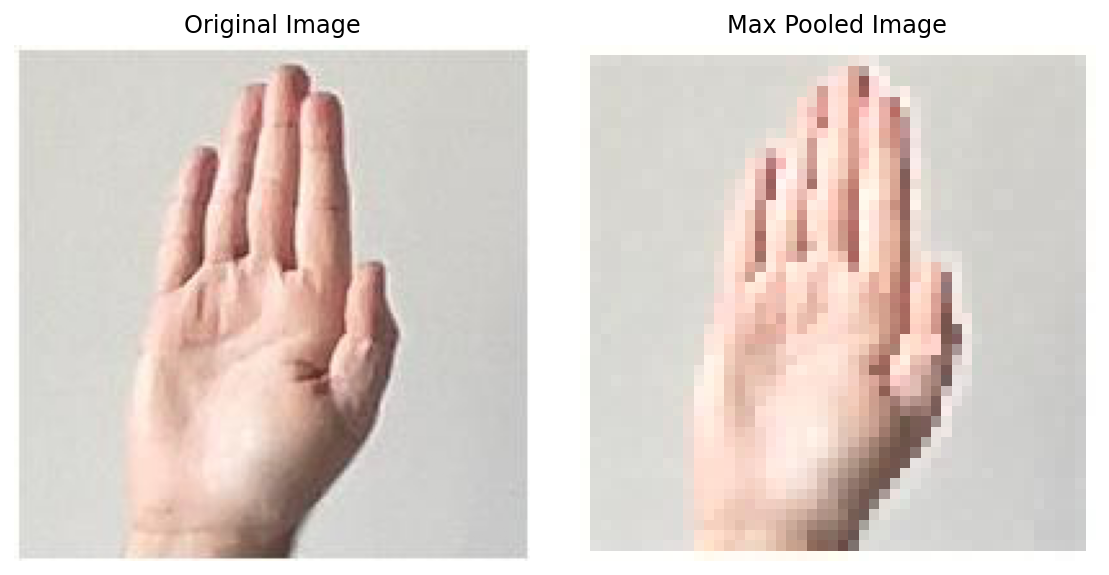

In [41]:
# Load the image
image_path = "data/cnn/image_data/paper/1.jpg"  
image = torchvision.io.read_image(image_path) / 255.0  

# Apply max pooling
max_pool = torch.nn.MaxPool2d(kernel_size=4, stride=4)
output = max_pool(image.unsqueeze(0))  # Unsqueeze to add a batch dimension

# Visualize the original image
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image.permute(1, 2, 0))  # Permute dimensions for displaying with matplotlib
plt.axis("off")

# Visualize the max pooled image
plt.subplot(1, 2, 2)
plt.title("Max Pooled Image")
plt.imshow(output.squeeze().permute(1, 2, 0))
plt.axis("off")

plt.tight_layout()
plt.show()


In [42]:
print(f'Original image size: {image.size()}')
print(f'Filtered image size: {output.size()}')

Original image size: torch.Size([3, 200, 200])
Filtered image size: torch.Size([1, 3, 50, 50])


### Visualizing Conv2d Layers

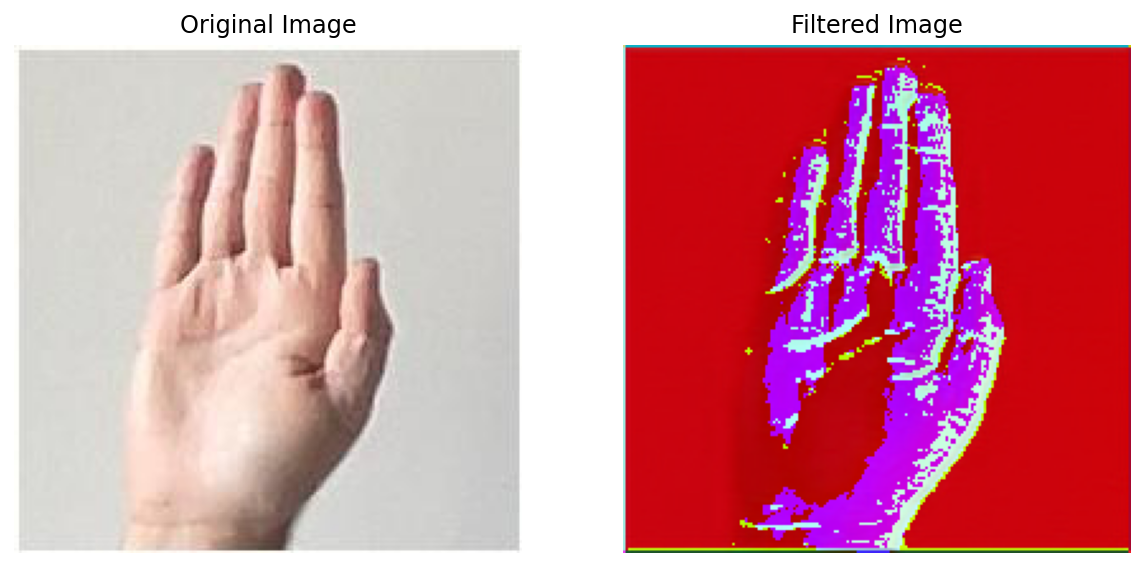

In [43]:
# Load the image
image_path = "data/cnn/image_data/paper/1.jpg"
image = Image.open(image_path)

# Define the transformation to be applied to the image
transform =  transforms.ToTensor() 

# Apply the transformation to the image
image_tensor = transform(image)

# Create a convolutional filter
conv_filter = torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)

# Apply the convolutional filter to the image tensor
filtered_image_tensor = conv_filter(image_tensor.unsqueeze(0))

# Convert the filtered image tensor back to a PIL image
filtered_image = transforms.ToPILImage()(filtered_image_tensor.squeeze(0))

# Display the original and filtered images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(filtered_image)
axes[1].set_title('Filtered Image')
axes[1].axis('off')
plt.show()


In [44]:
# self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3)
# self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
# self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
def conv2d_size(input_size, kernel_size, padding=0, stride=1, dilation=1):
    output_width = (input_size[0] + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1
    output_height = (input_size[1] + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1
    return output_width, output_height

def maxpool2d_size(input_size, kernel_size, stride=None, padding=0, dilation=1):
    if stride is None:
        stride = kernel_size  # Default stride is equal to kernel size
    
    output_width = (input_size[0] + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1
    output_height = (input_size[1] + 2 * padding - dilation * (kernel_size - 1) - 1) // stride + 1
    
    return output_width, output_height


In [45]:
one = conv2d_size((90,90), 3)
two = maxpool2d_size(one, kernel_size=2, stride=2)
conv2d_size(two, 5)

(40, 40)

In [46]:
print(f'Original image size: {image.size}')
print(f'Filtered image size: {filtered_image.size}')

Original image size: (200, 200)
Filtered image size: (200, 200)


## Defining a Criterion and Optimizer

In [47]:
# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [48]:
def train(model, train_loader, criterion):
    train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(train_loader)

In [49]:
def validate(model, test_loader, criterion):
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        return val_loss / len(test_loader), accuracy

In [50]:
best_val_loss = float('inf')
for epoch in range(Config.EPOCHS):
    train_loss = train(model, train_loader, criterion)
    val_loss, accuracy = validate(model, test_loader, criterion)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience = 0
        torch.save(model.state_dict(), 'model.p')
    
    else: 
        patience += 1

    if patience >= Config.PATIENCE:
        print('Early stopping reached')
        break
    
    print(f"Epoch: {epoch:02} - Train loss: {train_loss:02.3f} - Validation loss: {val_loss:02.3f} - Accuracy: {accuracy:02.3f}")

Epoch: 00 - Train loss: 1.099 - Validation loss: 1.095 - Accuracy: 39.000
Epoch: 01 - Train loss: 1.095 - Validation loss: 1.090 - Accuracy: 33.667
Epoch: 02 - Train loss: 1.092 - Validation loss: 1.082 - Accuracy: 40.333
Epoch: 03 - Train loss: 1.073 - Validation loss: 1.044 - Accuracy: 51.000
Epoch: 04 - Train loss: 0.992 - Validation loss: 0.848 - Accuracy: 62.333
Epoch: 05 - Train loss: 1.141 - Validation loss: 1.108 - Accuracy: 32.667
Epoch: 06 - Train loss: 1.099 - Validation loss: 1.090 - Accuracy: 32.667
Epoch: 07 - Train loss: 1.076 - Validation loss: 1.049 - Accuracy: 65.333
Epoch: 08 - Train loss: 0.954 - Validation loss: 0.789 - Accuracy: 65.333
Epoch: 09 - Train loss: 0.587 - Validation loss: 0.469 - Accuracy: 82.333
Epoch: 10 - Train loss: 0.404 - Validation loss: 0.276 - Accuracy: 88.333
Epoch: 11 - Train loss: 0.278 - Validation loss: 0.217 - Accuracy: 92.333
Epoch: 12 - Train loss: 0.173 - Validation loss: 0.162 - Accuracy: 93.667
Epoch: 13 - Train loss: 0.119 - Valida